Loading ResNet...
Loading U-Net...


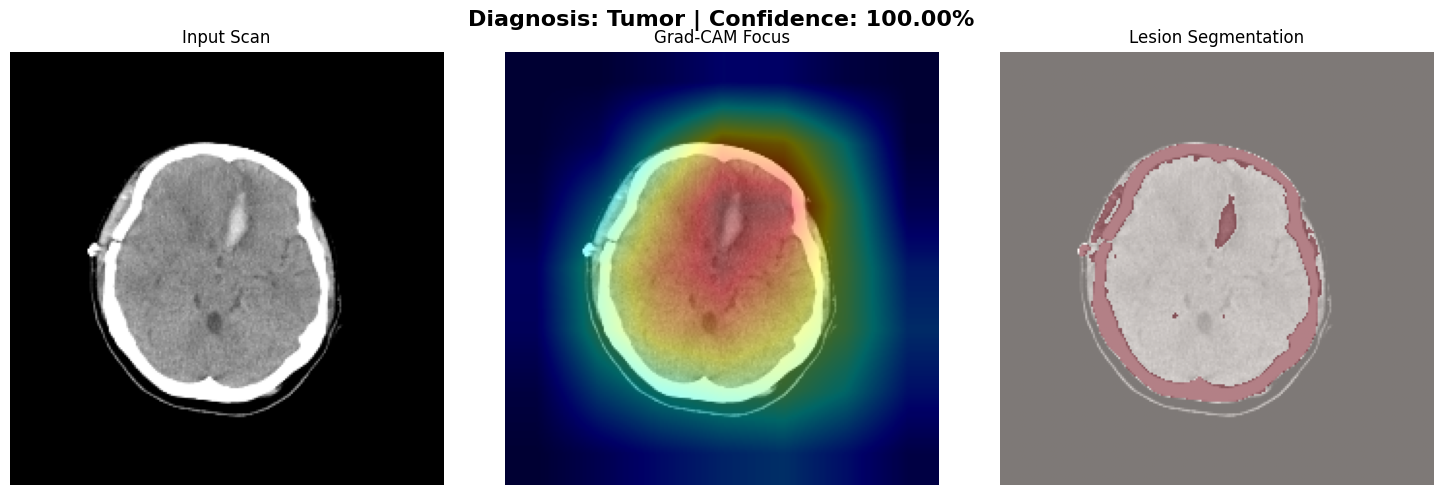

Done. Diagnosis: Tumor


In [3]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import os

# --- 1. Define Standard Classes (Must match training) ---
CLASSES = ["Hemorrhagic", "Ischemic", "Tumor"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Define Model Architectures (Must match training) ---
# We need to redefine these classes so PyTorch knows the structure when loading weights

import torch.nn as nn
from torchvision import models

def get_model():
    model = models.resnet50(pretrained=False) # No need to download weights, we load ours
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(CLASSES))
    return model.to(DEVICE)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def double_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
            )
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(64 + 128, 64)
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return torch.sigmoid(out)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)
        score = output[0, class_idx]
        score.backward()
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap)
        return heatmap

# --- 3. The Prediction Function ---
def predict_and_explain(image_path, 
                        class_model_path="best_resnet_model_safe_noisy_data.pth", 
                        seg_model_path="unet_lesion_model.pth"):
    
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return

    # Setup
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Load Classification Model
    print("Loading ResNet...")
    class_model = get_model()
    class_model.load_state_dict(torch.load(class_model_path, map_location=DEVICE))
    class_model.eval()
    
    # Load Segmentation Model
    print("Loading U-Net...")
    seg_model = UNet().to(DEVICE)
    seg_model.load_state_dict(torch.load(seg_model_path, map_location=DEVICE))
    seg_model.eval()
    
    # Process Image
    img_pil = Image.open(image_path).convert("RGB")
    input_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)
    
    # Run Prediction
    with torch.no_grad():
        class_output = class_model(input_tensor)
        probs = torch.softmax(class_output, dim=1)
        score, pred_idx = torch.max(probs, 1)
        
    predicted_class = CLASSES[pred_idx.item()]
    confidence = score.item() * 100
    
    # Run Grad-CAM
    grad_cam = GradCAM(class_model, class_model.layer4[-1])
    heatmap = grad_cam(input_tensor, pred_idx)
    
    # Run Segmentation
    with torch.no_grad():
        seg_mask = seg_model(input_tensor)
        seg_mask = seg_mask.cpu().squeeze().numpy()
        seg_mask_bin = (seg_mask > 0.5).astype(np.float32)
        
    # Visualization
    img_cv = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    img_cv = cv2.resize(img_cv, (224, 224))
    
    # Grad-CAM Overlay
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    gradcam_overlay = cv2.addWeighted(img_cv, 0.6, heatmap_colored, 0.4, 0)
    gradcam_overlay = cv2.cvtColor(gradcam_overlay, cv2.COLOR_BGR2RGB)
    
    # Original for display
    img_disp = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    
    # Plotting
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Diagnosis: {predicted_class} | Confidence: {confidence:.2f}%", fontsize=16, fontweight='bold')
    
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(img_disp)
    ax1.set_title("Input Scan")
    ax1.axis('off')
    
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(gradcam_overlay)
    ax2.set_title("Grad-CAM Focus")
    ax2.axis('off')
    
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(img_disp)
    ax3.imshow(seg_mask_bin, cmap='Reds', alpha=0.5)
    ax3.set_title("Lesion Segmentation")
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"Done. Diagnosis: {predicted_class}")

# --- HOW TO RUN ---
# Replace 'test_image.jpg' with the actual path to an image on your PC
predict_and_explain("./10002.png")